<H3>Imports</H3>

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

<H3>Read From CSV</H3>

In [235]:
user_df = pd.read_csv('../Data/takehome_users.csv',encoding ='ISO-8859-1')

In [236]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


<H3>Fix NAs</H3>

In [237]:
user_df['is_session_created'] = user_df.last_session_creation_time.notnull()
user_df.loc[user_df.last_session_creation_time.isnull(), 'last_session_creation_time'] = -1

In [238]:
user_df['is_invited'] = user_df.invited_by_user_id.notnull()
user_df.loc[user_df.invited_by_user_id.isnull(), 'invited_by_user_id'] = -1

In [239]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
is_session_created            12000 non-null bool
is_invited                    12000 non-null bool
dtypes: bool(2), float64(2), int64(4), object(4)
memory usage: 961.0+ KB


<H3> Read summary file into memory</H3>

In [240]:
user_summary_df = pd.read_csv('../Data/takehome_user_engagement.csv',encoding ='ISO-8859-1')

In [241]:
user_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


<H3> Only users logged in at least 3 seperate days in at least a week are considered adopted</H3>
<H5> To get this data, 1) timestamp as index 2) aggregate by date and user id using groupby. 3) Resample weekly.</H5>

In [242]:
user_summary_df.time_stamp = pd.to_datetime(user_summary_df.time_stamp)

In [243]:
user_summary_df.index = user_summary_df.time_stamp

In [244]:
user_summary_df_d_agg = user_summary_df.groupby([user_summary_df['time_stamp']
                         .dt.date, 'user_id']).visited.count().reset_index().set_index('time_stamp')

In [245]:
user_summary_df_d_agg.index = pd.to_datetime(user_summary_df_d_agg.index)

In [246]:
user_summary_df_w_agg = pd.DataFrame(user_summary_df_d_agg.groupby('user_id').resample('W')['user_id'].count())

In [247]:
user_summary_df_w_agg = user_summary_df_w_agg.reset_index(level=1)
user_summary_df_w_agg.columns == ['time_stamp', 'user']

array([ True, False], dtype=bool)

In [248]:
adopted_users = list(user_summary_df_w_agg[user_summary_df_w_agg['user_id']>1].index.unique())

In [249]:
user_df['adopted'] = False

In [250]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_session_created,is_invited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,True,True,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,True,True,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,True,True,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,True,True,False


In [253]:
user_df['adopted'] = user_df.object_id.isin(adopted_users)

In [254]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_session_created,is_invited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,True,True,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,True,True,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,True,True,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,True,True,False


<H2>EDA</H2>

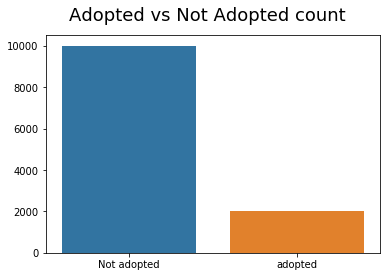

In [255]:
fig = plt.gcf()
fig.suptitle('Adopted vs Not Adopted count', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x=['Not adopted', 'adopted'], y=[user_df[user_df['adopted']!=True].adopted.count(), user_df[user_df['adopted']].adopted.count()])

plt.show()

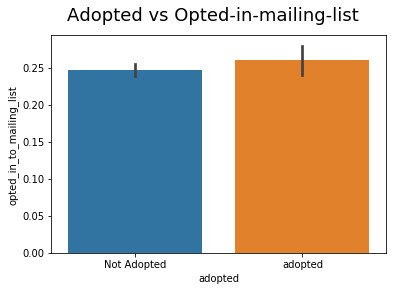

In [256]:
fig = plt.gcf()
fig.suptitle('Adopted vs Opted-in-mailing-list', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='adopted', y='opted_in_to_mailing_list', data=user_df)
plt.xticks([0,1], ['Not Adopted', 'adopted'])
plt.show()

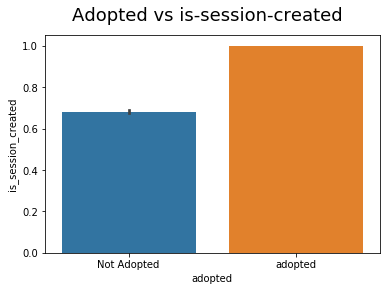

In [257]:
fig = plt.gcf()
fig.suptitle('Adopted vs is-session-created', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='adopted', y='is_session_created', data=user_df)
plt.xticks([0,1], ['Not Adopted', 'adopted'])
plt.show()

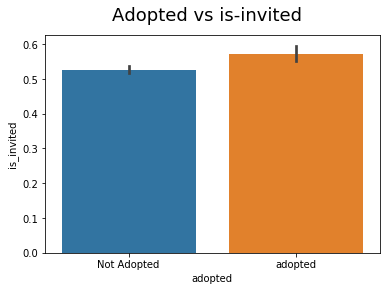

In [258]:
fig = plt.gcf()
fig.suptitle('Adopted vs is-invited', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='adopted', y='is_invited', data=user_df)
plt.xticks([0,1], ['Not Adopted', 'adopted'])
plt.show()

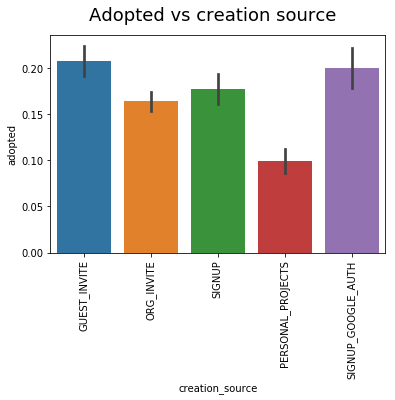

In [259]:
fig = plt.gcf()
fig.suptitle('Adopted vs creation source', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='creation_source', y='adopted', data=user_df)
plt.xticks(rotation=90)
plt.show()

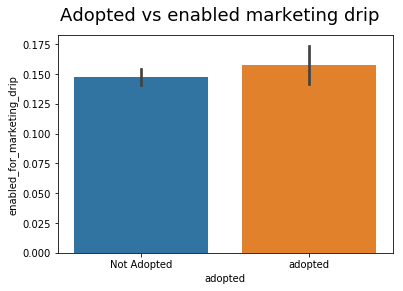

In [260]:
fig = plt.gcf()
fig.suptitle('Adopted vs enabled marketing drip', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='adopted', y='enabled_for_marketing_drip', data=user_df)
plt.xticks([0,1], ['Not Adopted', 'adopted'])
plt.show()

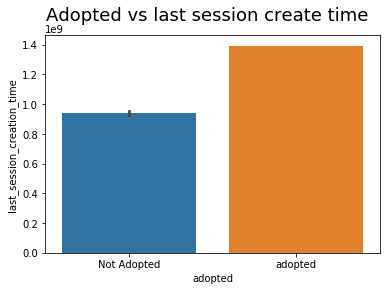

In [261]:
fig = plt.gcf()
fig.suptitle('Adopted vs last session create time', 
             fontsize=18, horizontalalignment = 'center')

sns.barplot(x='adopted', y='last_session_creation_time', data=user_df)
plt.xticks([0,1], ['Not Adopted', 'adopted'])
plt.show()

In [228]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
is_session_created            12000 non-null bool
is_invited                    12000 non-null bool
adopted                       12000 non-null bool
dtypes: bool(3), float64(2), int64(4), object(4)
memory usage: 972.7+ KB


<H3>Machine Learning</H3>

In [263]:
for source in user_df.creation_source.unique():
    user_df['creation_source_'+str(source)] = (user_df['creation_source']==source)

In [264]:
user_df['outcome'] =user_df['adopted']

In [265]:
user_df = user_df.drop('creation_source', axis=1)
user_df = user_df.drop('adopted', axis=1)

In [266]:
Xs = np.array(user_df.iloc[:, 4:-1], dtype='f')
ys =  np.array(user_df.iloc[:,-1], dtype='f')

X_train, X_test,y_train,  y_test = train_test_split(Xs,ys, test_size=0.3, random_state=21)

In [267]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
object_id                             12000 non-null int64
creation_time                         12000 non-null object
name                                  12000 non-null object
email                                 12000 non-null object
last_session_creation_time            12000 non-null float64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
is_session_created                    12000 non-null bool
is_invited                            12000 non-null bool
creation_source_GUEST_INVITE          12000 non-null bool
creation_source_ORG_INVITE            12000 non-null bool
creation_source_SIGNUP                12000 non-null bool
creation_source_PERSONAL_PROJECTS     12000 non-null bool
creat

In [268]:
pipe = Pipeline([('selectKBest', SelectKBest()), ('clf', RandomForestClassifier())])
param_grid = {
    'clf__n_estimators' : range(1,10,1),
    'selectKBest__k' : range(2,12,1)
}

grid =GridSearchCV(pipe, param_grid, cv=5 )
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectKBest', SelectKBest(k=10, score_func=<function f_classif at 0x1a100cc2f0>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': range(1, 10), 'selectKBest__k': range(2, 12)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [269]:
grid.best_score_

0.8861904761904762

In [270]:
y_pred = grid.predict(X_test)
grid.score(X_test, y_test)

0.88749999999999996

In [271]:
grid.best_params_

{'clf__n_estimators': 7, 'selectKBest__k': 11}

In [272]:
features = [False, False, False, False]

features.extend(list(grid.best_estimator_.named_steps['selectKBest'].get_support()))
features.append(False)

user_df.loc[:,features].columns

Index(['last_session_creation_time', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'is_session_created', 'is_invited',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_SIGNUP', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [273]:
confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,2864,144,3008
1.0,261,331,592
All,3125,475,3600


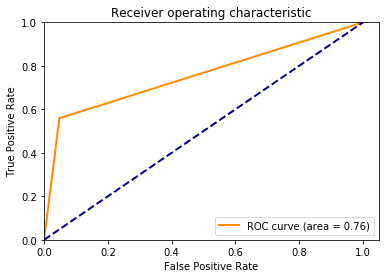

In [274]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<H3> Conclusion</H3>

1) The model is 88%(Mean accuracy) accurate on Training and Test Data.
2) The ROC curve accuracy is 0.75

<H3> Findings</H3>


1) The creation source plays a major role in the behaviour of the user. Guest invite and signup google auth users seem to be adopted more than other users.
2) The last session create time seems to be higher for adopted users.

<H3> Suggestions </H3>

1) Less than 20% of the population is adopted. This value needs to be improved.
2) Concentrate more on users signing up using org invite, self signups and 